# Projekt Data Analytics
## Przewidywanie i analiza stanu cywilnego ludności USA na przestrzeni lat 

Autorzy: Julia Nowak, Adam Złocki

### 1. Problem Statement


##### Main Problem
The goal of the project is to predict the number of adult married individuals in the U.S. society. The problem does not focus on specific races; general data common to all races has been accepted. However, the selected dataset allows for dividing the data into specific races and separate analysis of marital status. The idea of the project is based on the current topic concerning the hypothetical decline in the number of marriages and the increase in the number of divorces in highly developed countries such as the USA. During the analysis, we want to demonstrate existing trends and predict the distribution of the values we are interested in for the future.

##### Examples of Use and Reasons for Analysis
The problem of predicting marital status and the number of marriages in society is extremely important information from the government's perspective. This is a problem worth analyzing, especially for planning the U.S. government's family policy. The topic is also significant for all types of estimates related to natural population growth or social conditions. The analysis can provide the government with early indications of certain changes occurring in society, which should be considered when creating future plans.

##### Data Origin and Content
The data we are using comes from the official U.S. government website (www.census.gov). It includes information on the number of people with a given marital status by year, the average age of first marriage, the number of available housing units, and the overall average income per household member to present the general economic situation of the society.

Additionally, the data is available with a division by race, allowing for predictions for each race separately and subsequent comparative analysis, although we did not adopt this approach. The data we use is historical, spanning from the 20th century to 2023, with the latest update in November 2023, making it relatively recent. For the analysis, we used the years 1993-2023, excluding duplicates of some years (choosing the most recent data from each pair).

The data includes various tables from the Current Population Survey (CPS), conducted annually by the U.S. Census Bureau.

##### DAG Diagram
The following DAG diagram represents the dependencies utilized in our project. For our predictions, we applied average household income per member and the number of available housing units, allowing us to examine the impact of the overall economic situation of society on the number of marriages. Additionally, we also took into account the average age of first marriage.


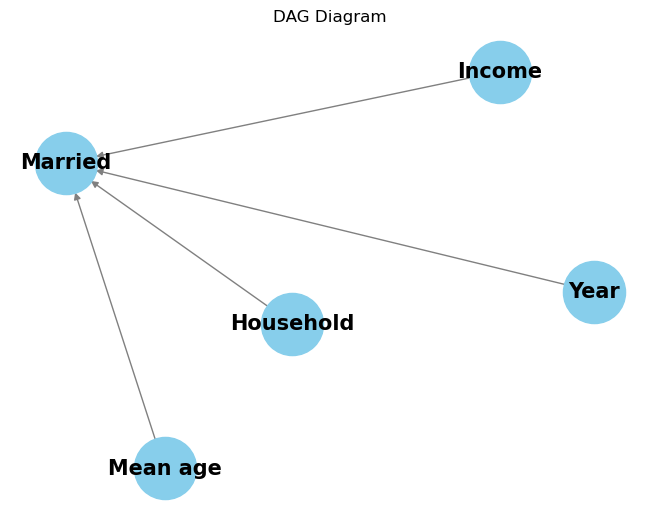

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Married")
G.add_node("Mean age")

# Add edges
G.add_edge("Year", "Married")
G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

# Add edge labels
# edge_labels = {
#     ("Income", "Married"): "predictor",
#     ("Household", "Married"): "predictor",
#     ("Mean age", "Married"): "predictor"
# }
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("DAG Diagram")
plt.show()


### 2. Data Preprocessing

1. Selection of Analyzed Years and Races:

- Years 1993-2022 were chosen for analysis (almost 30 years of data).
- Years 2018-2023 were set aside for model evaluation.
- The focus was on analyzing overall data across all races combined.

2. Data Notes:

- In years 2011 and 2021, the data included duplicate results due to presenting both original and updated values based on the latest decennial population census (updated values were adopted).
- In 2014, there was a change in income-related survey questions, resulting in differences in questions asked to respondents.
- Since 2019, same-sex marriages have also been included.

3. Cleaning and Operations:

- Year format was changed from "..2011" to a format without dots.
- Year 2023 was excluded due to income data being from previous years.
- Duplicate years were removed.
- Data was merged to omit gender considerations.
- Total respondents were calculated (including data beyond the analyzed period).
- Household data was selected from a separate database for improved results.
- Years were transformed into numbers and data types were standardized.

##### Import necessary libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
warnings.filterwarnings('ignore')
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats



c:\Users\adamz\Desktop\Data Analitics\DA_project\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Reading data from a concatenated file

In [5]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household", "Total"]]

##### Data splitting

In [6]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household,Total
0,1993,114601,15500,25.50,96391,197254
1,1994,115253,16300,25.60,97107,200800
2,1995,116554,16940,25.70,98990,202732
3,1996,116561,17850,25.95,99627,204624
4,1997,116752,18940,25.90,101018,207235


##### Preliminary data analysis

In [7]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000,229046.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469,19449.196392
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000,211676.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000,230272.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000,245275.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000,259063.000000


In [8]:
# Data for checking purposes
df_all.describe()

,Year,Married,Income per member,Mean age,Household,Total
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2007.500000,127399.333333,26878.666667,27.095000,114955.166667,235071.200000
std,8.803408,7444.099549,7382.727154,1.262069,10777.675445,22400.099328
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000,197254.000000
25%,2000.250000,120932.750000,22230.000000,26.000000,105581.000000,215089.250000
50%,2007.500000,129288.500000,26325.000000,26.650000,116397.000000,236920.500000
75%,2014.750000,133319.250000,30940.000000,28.150000,124247.500000,254318.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000,268583.000000


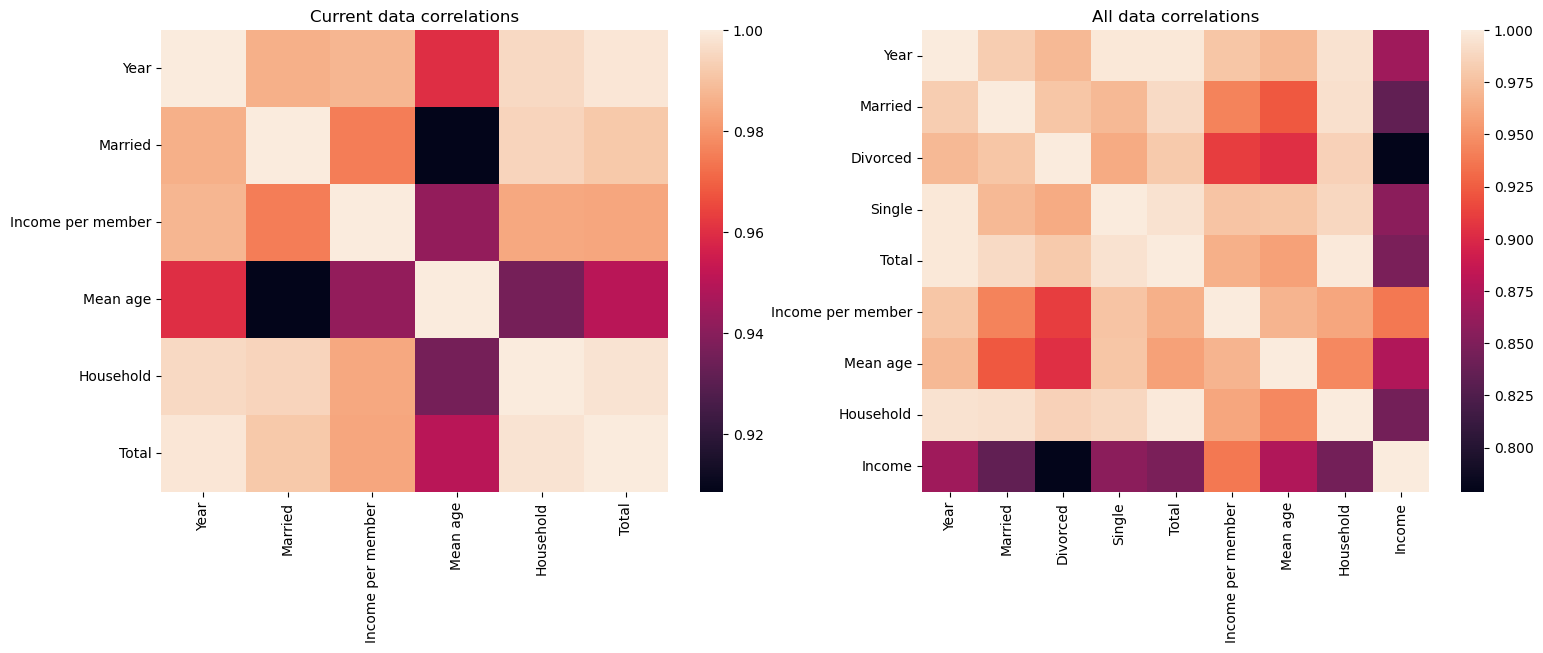

In [9]:
# Correlations

fig, ax =plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Current data correlations')
sns.heatmap(df.corr(), ax=ax[0])

ax[1].set_title('All data correlations')
sns.heatmap(df_ac.corr(), ax=ax[1])

plt.show()


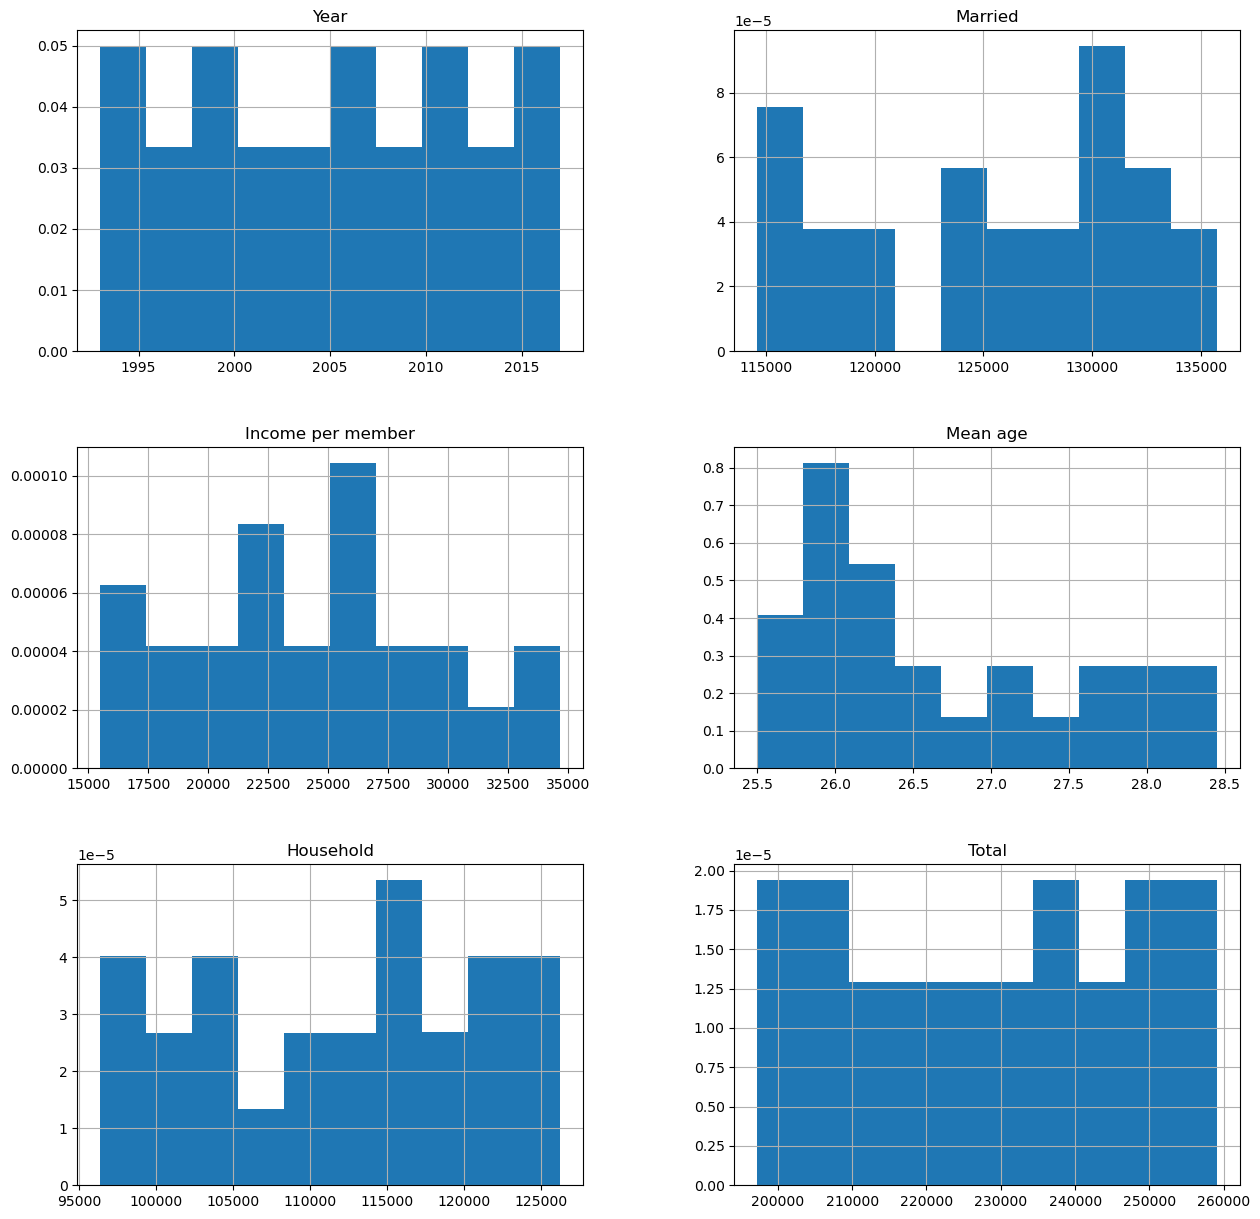

In [10]:
df.hist(figsize=(15,15), bins=10, density=True)
plt.show()

### 3. Model creation

- We have created two models - the first model predicts the number of individuals after marriage based on data about average household income per member. The second model additionally utilizes the number of available housing units and the average age of entering first marriage.

- We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model 1:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- równanie...

Model 2:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of available housing units, average age of first marriage
- równanie...


In [11]:
N = 25
R = 30

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

15:13:36 - cmdstanpy - INFO - compiling stan file C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_posterior.stan to exe file C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_posterior.exe


ValueError: Failed to compile Stan model 'C:\Users\adamz\Desktop\Data Analitics\DA_project\tri_posterior.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.hpp C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials  -D_USE_MATH_DEFINES  -DBOOST_DISABLE_ASSERTS          -c  -x c++ -o C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.o C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.hpp
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unused-function -Wno-uninitialized -Wno-unused-but-set-variable -Wno-unused-variable -Wno-sign-compare -Wno-unused-local-typedefs -Wno-int-in-bool-context -Wno-attributes -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials  -D_USE_MATH_DEFINES  -DBOOST_DISABLE_ASSERTS               -Wl,-L,"C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/bin/cmdstan/stan/lib/stan_math/lib/tbb" -Wl,-rpath,"C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/bin/cmdstan/stan/lib/stan_math/lib/tbb"        C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.o src/cmdstan/main.o  -static-libgcc -static-libstdc++     -Wl,-L,"C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/bin/cmdstan/stan/lib/stan_math/lib/tbb" -Wl,-rpath,"C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/bin/cmdstan/stan/lib/stan_math/lib/tbb"     stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_nvecserial.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_cvodes.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_idas.a stan/lib/stan_math/lib/sundials_6.1.1/lib/libsundials_kinsol.a  stan/lib/stan_math/lib/tbb/tbb.dll -o C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.exe
C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/mingw-w64/bin/../lib/gcc/x86_64-w64-mingw32/5.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: cannot find C:/Users/adamz/Desktop/Data: No such file or directory
C:/Users/adamz/Desktop/Data Analitics/DA_project/.conda/Library/mingw-w64/bin/../lib/gcc/x86_64-w64-mingw32/5.3.0/../../../../x86_64-w64-mingw32/bin/ld.exe: cannot find Analitics/DA_project/.conda/Library/mingw-w64/bin/../lib/gcc/x86_64-w64-mingw32/5.3.0/../../../../x86_64-w64-mingw32/lib/../lib/default-manifest.o: No such file or directory
collect2.exe: error: ld returned 1 exit status
make/program:56: recipe for target 'C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.exe' failed
mingw32-make: *** [C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.exe] Error 1

Command ['mingw32-make', 'C:/Users/adamz/Desktop/DATAAN~1/DA_PRO~1/tri_posterior.exe']
	error during processing No such file or directory


### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt] - The prior parameters were chosen by fitting a function that closely resembled the trend of marriages over the years. In this case, it turned out to be a linear function (for the first model) or closely approximated a linear function within this range (for the second model).

#### 4.1. Model 1.

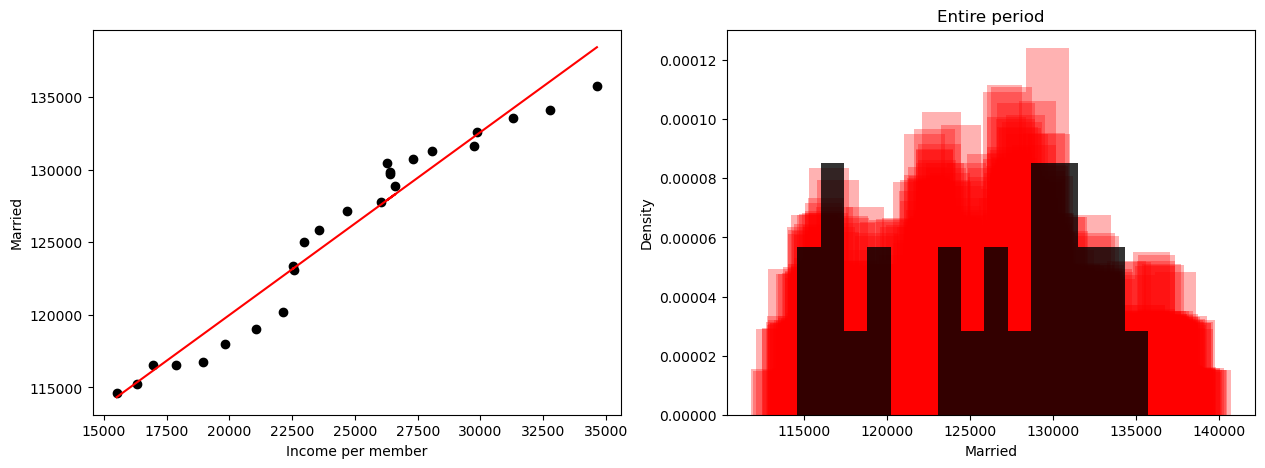

In [12]:
# Parameter testing for Model 1

A = np.vstack([df['Income per member'], np.ones(len(df['Income per member']))]).T

# Parameter match - function modelling
a, b = np.linalg.lstsq(A, df['Married'], rcond=None)[0]

alpha = 1.26
beta = 94800
sigma = 1000

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(df['Income per member'], df['Married'], color='black')
plt.plot(df['Income per member'], alpha*df['Income per member'] + beta, color='red')
plt.xlabel('Income per member')
plt.ylabel('Married')


plt.subplot(1,2,2)
sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))

for i in range(len(sim)):
    plt.hist(sim[i], color='red', alpha = 0.3, density=True)

plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

In [13]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

15:19:06 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


15:19:06 - cmdstanpy - INFO - CmdStan done processing.


In [14]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.36833,96354.4,363.8660,117610.0,118153.0,119623.0,121215.0,123095.0,...,132869.0,132274.0,132493.0,133983.0,135088.0,136976.0,137248.0,138562.0,141258.0,143517.0
1,0.0,0.0,1.30723,94514.1,920.0090,115364.0,116217.0,114048.0,118800.0,119756.0,...,129539.0,127583.0,128503.0,129990.0,131911.0,133667.0,134140.0,134327.0,137372.0,139793.0
2,0.0,0.0,1.30859,96319.1,1369.8500,118216.0,119311.0,119569.0,120729.0,118866.0,...,129315.0,131678.0,133251.0,131625.0,130420.0,135758.0,135552.0,135992.0,140686.0,141617.0
3,0.0,0.0,1.27481,93623.4,1448.9200,114056.0,113217.0,114995.0,113639.0,116321.0,...,126038.0,126968.0,129143.0,128354.0,128789.0,129899.0,129919.0,135577.0,135152.0,137551.0
4,0.0,0.0,1.28421,95587.9,1441.3400,112428.0,116838.0,114093.0,117634.0,118647.0,...,128524.0,129962.0,130414.0,131389.0,129824.0,135225.0,134861.0,134208.0,139137.0,140184.0
5,0.0,0.0,1.25440,95516.4,1588.6000,115357.0,114750.0,118564.0,116937.0,119177.0,...,129235.0,126909.0,128203.0,128992.0,132839.0,131787.0,132627.0,133264.0,136298.0,140491.0
6,0.0,0.0,1.28807,96690.2,1200.1300,115455.0,115550.0,118715.0,118619.0,119441.0,...,132007.0,130187.0,131116.0,131732.0,132871.0,135483.0,137043.0,139486.0,141733.0,141598.0
7,0.0,0.0,1.25677,95355.2,615.7430,115384.0,116017.0,117177.0,118132.0,119254.0,...,128365.0,126763.0,128145.0,129220.0,130156.0,133541.0,133390.0,135025.0,137417.0,139193.0
8,0.0,0.0,1.29109,98321.7,1547.9300,118073.0,118255.0,121154.0,122357.0,123511.0,...,130221.0,131720.0,133099.0,131137.0,134658.0,134445.0,135174.0,138853.0,141658.0,141923.0
9,0.0,0.0,1.23215,92709.9,1588.1100,114305.0,114876.0,112422.0,114987.0,115828.0,...,123322.0,122590.0,124012.0,125391.0,128307.0,132825.0,129838.0,130084.0,134948.0,135123.0


In [ ]:
# for i in range(len(gen_1.y_sim)):
#     plt.plot(df['Income per member'], gen_1.alpha[i]*df['Income per member'] + gen_1.beta[i], color='black', alpha = 0.1)
# plt.plot(df['Income per member'], gen_1.alpha[i].mean()*df['Income per member'] + gen_1.beta.mean(), color='red')   
# plt.scatter(df['Income per member'], df['Married'], color='green')
# plt.show()

30


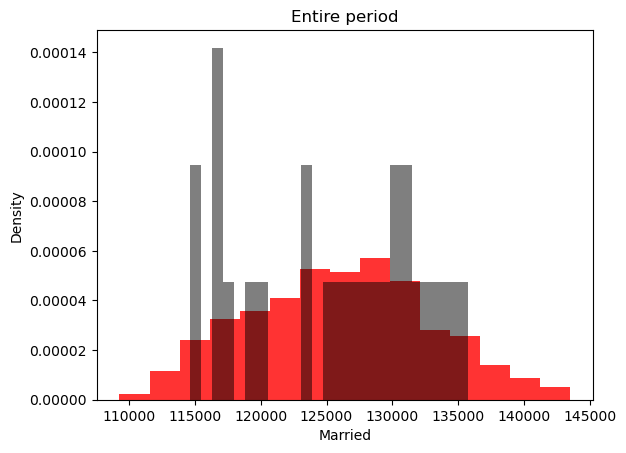

In [18]:
prior_1_combined = []
for i in range(R):
    prior_1_combined.extend(prior_1.y_sim[i])

plt.hist(prior_1_combined, bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

#### 4.2. Model 2.

In [20]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

15:28:57 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


15:28:57 - cmdstanpy - INFO - CmdStan done processing.


In [21]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.019708,0.827772,1278.73,67755.2,30.52890,114639.0,115118.0,116568.0,...,129698.0,129730.0,129840.0,131444.0,132142.0,132936.0,133179.0,134252.0,134915.0,135173.0
1,0.0,0.0,0.016840,0.826388,1280.43,61824.4,151.75300,108648.0,109157.0,110371.0,...,123749.0,123691.0,123846.0,125205.0,126073.0,126925.0,127297.0,128326.0,128931.0,129302.0
2,0.0,0.0,0.018213,0.827903,1280.77,64232.6,213.50200,111398.0,111378.0,113069.0,...,126197.0,125987.0,126517.0,127925.0,128697.0,129344.0,129849.0,130854.0,131189.0,131632.0
3,0.0,0.0,0.015109,0.810013,1281.22,65800.5,85.42390,111031.0,111641.0,112798.0,...,125706.0,125715.0,125876.0,127458.0,128170.0,128745.0,129119.0,129986.0,130717.0,130995.0
4,0.0,0.0,0.017259,0.804668,1278.98,69734.9,75.37300,114390.0,114768.0,116208.0,...,129024.0,129068.0,129223.0,130739.0,131325.0,132290.0,132329.0,133438.0,134037.0,134450.0
5,0.0,0.0,0.015675,0.835133,1280.34,71416.4,100.49600,119124.0,119527.0,120912.0,...,134320.0,134197.0,134223.0,136079.0,136671.0,137489.0,137900.0,138899.0,139676.0,139892.0
6,0.0,0.0,0.017465,0.809688,1280.23,66823.1,101.59400,111887.0,112479.0,113748.0,...,126699.0,126766.0,126830.0,128387.0,129079.0,130013.0,129996.0,131066.0,131793.0,131949.0
7,0.0,0.0,0.017406,0.816436,1279.01,70842.0,64.86280,116485.0,117059.0,118445.0,...,131553.0,131553.0,131668.0,133223.0,133955.0,134700.0,134950.0,135982.0,136640.0,136893.0
8,0.0,0.0,0.016145,0.817699,1278.41,66829.3,123.20500,112602.0,113251.0,114463.0,...,127640.0,127641.0,127899.0,129495.0,130002.0,130855.0,130906.0,132099.0,132711.0,132878.0
9,0.0,0.0,0.015630,0.804328,1279.24,66248.1,131.82000,111202.0,111378.0,112628.0,...,125781.0,125647.0,125786.0,127201.0,127737.0,128504.0,128910.0,130083.0,130553.0,131051.0


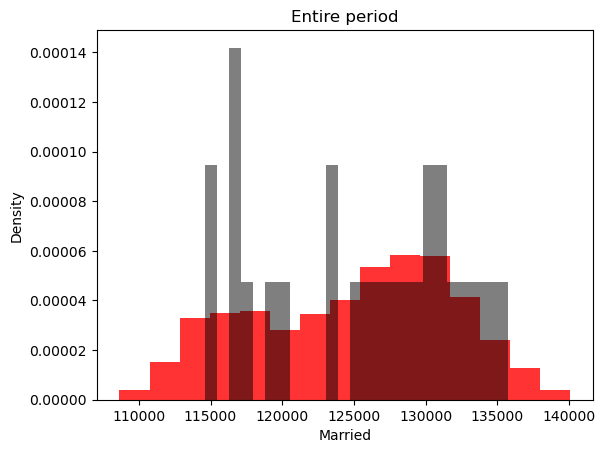

In [22]:
prior_2_combined = []
for i in range(R):
    prior_2_combined.extend(prior_2.y_sim[i])
plt.hist(prior_2_combined, bins=15, color='red', alpha = 0.8, density=True)
plt.hist(df['Married'], bins=25, color='black', alpha = 0.5, density=True)
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

### 5. Posterior (model 1) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [23]:
data = {'N': N, 'income': df['Income per member'], 'y': df['Married']}
post_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=100)

15:29:44 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


15:29:45 - cmdstanpy - INFO - CmdStan done processing.


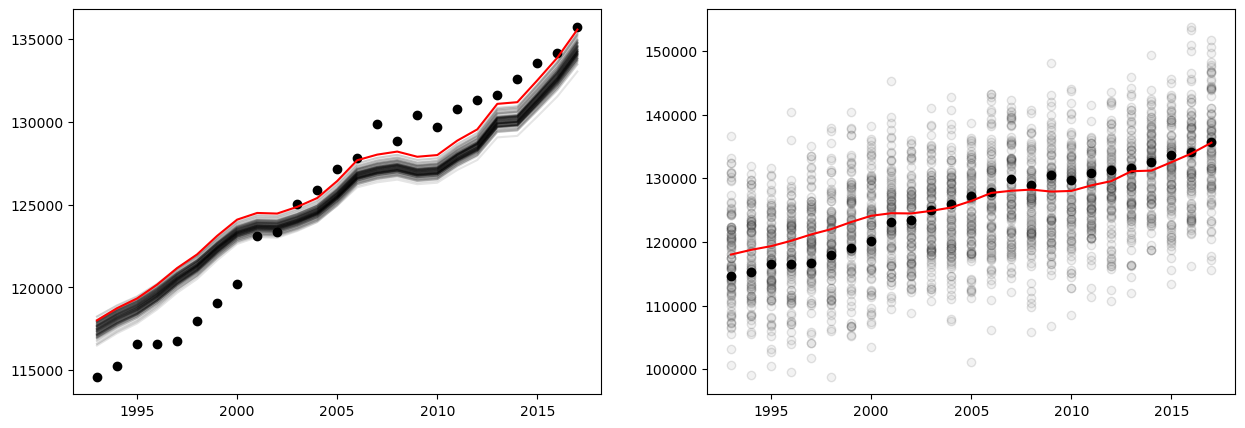

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_1.y_sim)):
    plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_1.alpha[i].mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_1.y_sim)):
    plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_1.alpha[i].mean()*df['Income per member'] + post_1.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [25]:
post_1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-6054.570000,0.198034,1.232540,-6056.950000,-6054.440000,-6052.97000,38.7369,1291.230,0.991656
alpha,0.882167,0.004263,0.031509,0.830735,0.884686,0.93650,54.6275,1820.920,1.021360
beta,103779.000000,111.666000,785.867000,102331.000000,103770.000000,104973.00000,49.5286,1650.950,1.043030
sigma,6995.490000,43.053700,209.834000,6646.940000,7041.070000,7267.28000,23.7536,791.785,1.025960
y_sim[1],118012.000000,842.909000,7240.020000,106685.000000,118071.000000,130749.00000,73.7767,2459.220,1.009040
y_sim[2],118390.000000,608.553000,6678.160000,107806.000000,118623.000000,129042.00000,120.4250,4014.170,0.989951
y_sim[3],117415.000000,644.282000,6467.900000,105976.000000,117367.000000,127891.00000,100.7800,3359.330,0.996740
y_sim[4],118278.000000,728.771000,6858.760000,107150.000000,118429.000000,128000.00000,88.5745,2952.480,1.010550
y_sim[5],119807.000000,629.500000,6715.500000,105913.000000,119790.000000,131666.00000,113.8060,3793.530,0.996625
y_sim[6],119607.000000,708.800000,7034.320000,108506.000000,119482.000000,131322.00000,98.4912,3283.040,0.989973


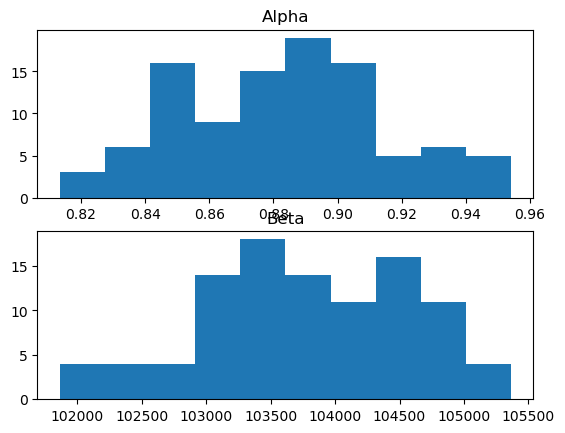

In [26]:
plt.subplot(2,1,1)
plt.hist(post_1.alpha)
plt.title('Alpha')

plt.subplot(2,1,2)
plt.hist(post_1.beta)
plt.title('Beta')

plt.show()

### 6. Posterior (model 2) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [27]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

NameError: name 'model_2_posterior' is not defined

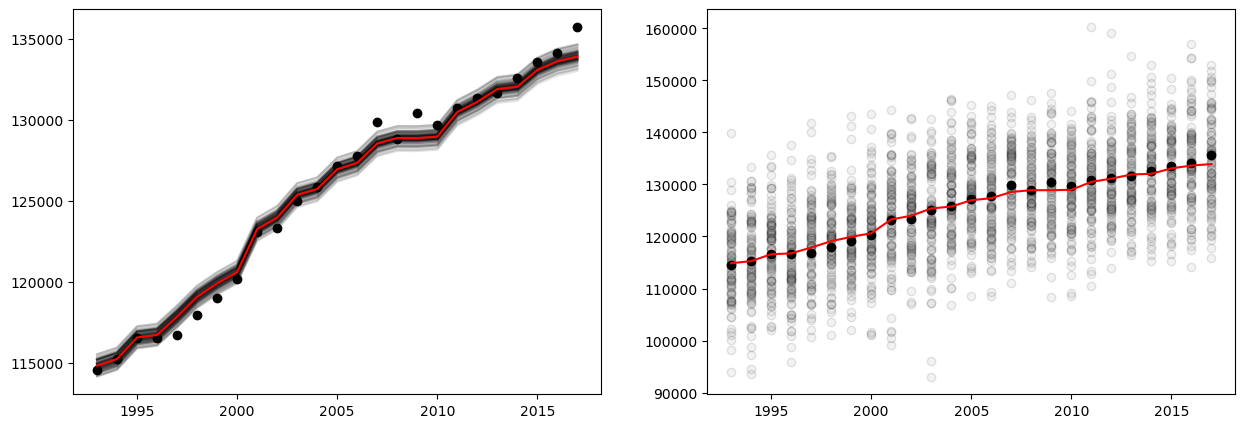

In [922]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], -post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], -post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [923]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-6109.690000,0.198912,1.273160,-6111.640000,-6109.600000,-6107.870000,40.9680,706.345,1.021170
alpha_1,0.017197,0.000126,0.001009,0.015602,0.017102,0.018962,64.0918,1105.030,0.997754
alpha_2,0.776552,0.001120,0.009673,0.762505,0.774856,0.793309,74.5596,1285.510,1.010890
alpha_3,1280.060000,0.205025,0.951942,1278.440000,1280.170000,1281.450000,21.5581,371.691,1.033380
beta,72906.800000,132.761000,1100.510000,70958.300000,73132.800000,74415.100000,68.7143,1184.730,1.017200
sigma,7757.050000,14.054300,142.981000,7518.770000,7757.680000,8028.430000,103.4990,1784.470,1.008790
y_sim[1],114965.000000,763.702000,7517.220000,101709.000000,115020.000000,124936.000000,96.8874,1670.470,1.018830
y_sim[2],115551.000000,870.680000,8262.250000,100942.000000,114876.000000,129303.000000,90.0492,1552.570,1.003980
y_sim[3],117769.000000,701.881000,7109.870000,105671.000000,119228.000000,129362.000000,102.6120,1769.160,0.993649
y_sim[4],115701.000000,802.980000,7969.850000,101768.000000,115016.000000,129691.000000,98.5123,1698.490,0.994532


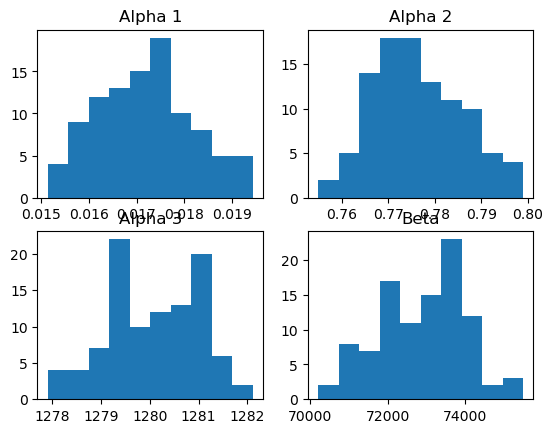

In [935]:
plt.subplot(2,2,1)
plt.hist(post_2.alpha_1)
plt.title('Alpha 1')

plt.subplot(2,2,2)
plt.hist(post_2.alpha_2)
plt.title('Alpha 2')

plt.subplot(2,2,3)
plt.hist(post_2.alpha_3)
plt.title('Alpha 3')

plt.subplot(2,2,4)
plt.hist(post_2.beta)
plt.title('Beta')

plt.show()

### 7. Porównanie modeli

- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

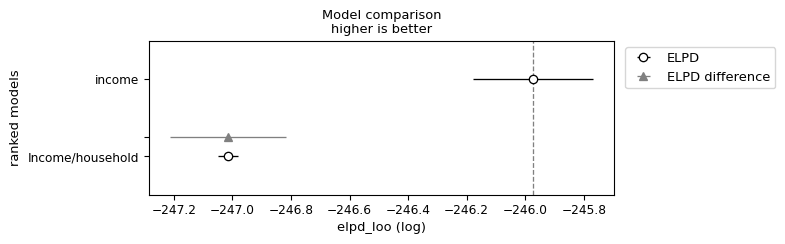

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
income,0,-245.973401,0.015598,0.000000,1.0,0.203732,0.000000,False,log
Income/household,1,-247.015718,0.008768,1.042316,0.0,0.034963,0.197631,False,log


In [924]:
# Compare the models using LOO
loo_compare = az.compare({"income": post_1, "Income/household": post_2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

In [925]:
az.loo(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -245.97     0.20
p_loo        0.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       25  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [926]:
az.loo(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -247.02     0.03
p_loo        0.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       25  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

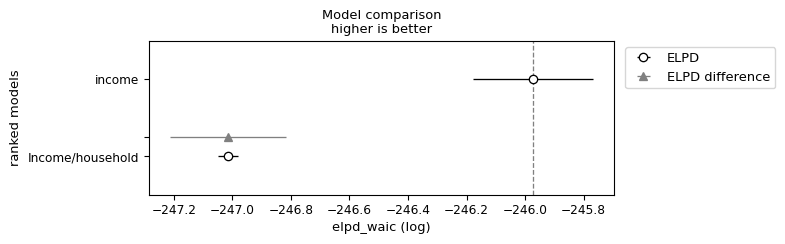

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
income,0,-245.973079,0.015276,0.000000,1.0,0.203735,0.000000,False,log
Income/household,1,-247.015465,0.008516,1.042386,0.0,0.034964,0.197632,False,log


In [927]:
# Compare the models using WAIC
waic_compare = az.compare({"income": post_1, "Income/household": post_2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare

In [928]:
az.waic(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -245.97     0.20
p_waic        0.02        -

In [929]:
az.waic(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -247.02     0.03
p_waic        0.01        -

In [930]:
data = {'N': 5, 'income': df_all['Income per member'][25:], 'y': df_all['Married'][25:]}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 5, 'income': df_all['Income per member'][25:], 'household': df_all['Household'][25:], 'mean_age': df_all['Mean age'][25:], 'y': df_all['Married'][25:]}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

02:13:04 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


02:13:05 - cmdstanpy - INFO - CmdStan done processing.
02:13:05 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:02 Sampling completed                     


02:13:08 - cmdstanpy - INFO - CmdStan done processing.


In [ ]:
post_test_1.draws_pd()

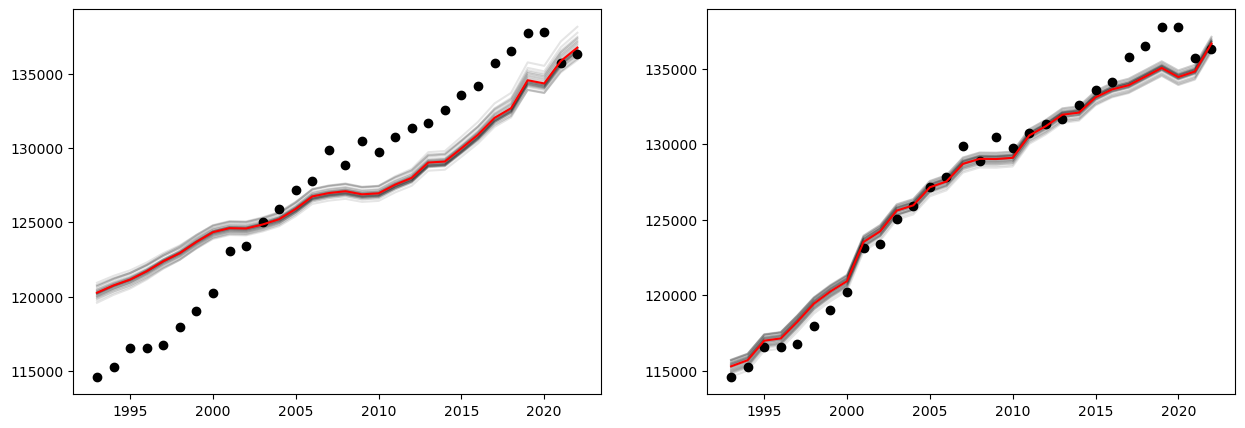

In [931]:
plt.figure(figsize=(15,5))

df_all = df_all[25:]
plt.subplot(1,2,1)
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], -post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], -post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()